In [1]:
import numpy as np
import pandas as pd
import keras
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Input, Lambda,GRU,Embedding
from keras.optimizers import RMSprop
from keras.utils.np_utils import to_categorical
from keras import backend as K
from keras.layers import Merge
import cPickle as pickle
import numpy

Using TensorFlow backend.


In [2]:
f = open("quora_all_data", "r")
sequences1 = pickle.load(f)
sequences2 = pickle.load(f)
y = pickle.load(f)
embedding_matrix = pickle.load(f)
f.close()

In [3]:
y = y.tolist()

In [4]:
from keras.preprocessing.sequence import pad_sequences

In [5]:
sequences1 = pad_sequences(sequences1, maxlen=50)
sequences2 = pad_sequences(sequences2, maxlen=50)

In [6]:
X_train = [sequences1[0:int(0.8*len(sequences1))], sequences2[0:int(0.8*len(sequences2))]]
y_train = y[0:int(0.8*len(sequences1))]
X_val = [sequences1[int(0.8*len(sequences1)):int(0.9*len(sequences1))], sequences2[int(0.8*len(sequences1)):int(0.9*len(sequences1))]]
y_val = y[int(0.8*len(sequences1)):int(0.9*len(sequences1))]
X_test = [sequences1[int(0.9*len(sequences1)):], sequences2[int(0.9*len(sequences1)):]]
y_test = y[int(0.9*len(sequences1)):]

In [7]:
input_dim = embedding_matrix.shape[0]
output_dim = embedding_matrix.shape[1]

In [32]:
model = Sequential()
model.add(Embedding(input_dim,output_dim,input_length=50, mask_zero=False,trainable=False,weights=[embedding_matrix], name='embed'))
model.add(GRU(units=128, kernel_initializer='he_normal', name='rnn',  return_sequences = False))
model.add(Dropout(0.5))

In [33]:
model.get_layer('rnn').input_shape

(None, 50, 300)

In [34]:
X_train = numpy.array(X_train)
y_train = numpy.array(y_train)
X_val = numpy.array(X_val)
y_val = numpy.array(y_val)
X_test = numpy.array(X_test)
y_test = numpy.array(y_test)

In [35]:
input_a = Input(shape = (X_train[0].shape[1],))
input_b = Input(shape = (X_train[1].shape[1],))

In [36]:
processed_a = model(input_a)
processed_b = model(input_b)

In [37]:
similarity = Lambda(lambda x: ((x[0]-x[1])*(x[0]-x[1])), output_shape=[128])([processed_a, processed_b])

In [38]:
similarity.shape

TensorShape([Dimension(None), Dimension(128)])

In [39]:
predictions = Dense(1,activation='sigmoid', name = 'last_dense')(similarity)
main_model = Model([input_a, input_b], predictions)

In [40]:
model.input_shape

(None, 50)

In [41]:
rms = RMSprop()
main_model.compile(loss='binary_crossentropy', optimizer=rms, metrics=['accuracy'])

In [42]:
filepath='weights-improvement-{epoch:02d}-{val_acc:.2f}.hdf5'
checkpoint = keras.callbacks.ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_weights_only=True, mode='max')
earlystop = keras.callbacks.EarlyStopping(monitor='val_acc', min_delta=0, patience=2, verbose=1, mode='auto')

In [43]:
class LossHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.history = {'loss':[], 'acc':[], 'val_loss':[], 'val_acc':[]}

    def on_batch_end(self, batch, logs={}):
        self.history['loss'].append(logs.get('loss'))
        self.history['acc'].append(logs.get('acc'))
    
    def on_epoch_end(self, batch, logs={}):
        self.history['val_loss'].append(logs.get('val_loss'))
        self.history['val_acc'].append(logs.get('val_acc'))

In [44]:
history = LossHistory()

In [45]:
callbacks_list = [checkpoint, history, earlystop]

In [46]:
main_model.fit([X_train[0],X_train[1]],y_train, epochs=10, batch_size=128,verbose=1,
               callbacks=callbacks_list, shuffle=True,validation_data=([X_val[0],X_val[1]],y_val))

Train on 239415 samples, validate on 29927 samples
Epoch 1/10
239415/239415 [==============================] - 1668s - loss: 0.5377 - acc: 0.7260 - val_loss: 0.5689 - val_acc: 0.7038
Epoch 2/10
239415/239415 [==============================] - 1597s - loss: 0.4852 - acc: 0.7627 - val_loss: 0.5634 - val_acc: 0.7315
Epoch 3/10
239415/239415 [==============================] - 1597s - loss: 0.4599 - acc: 0.7776 - val_loss: 0.5594 - val_acc: 0.7366
Epoch 4/10
239415/239415 [==============================] - 1599s - loss: 0.4405 - acc: 0.7891 - val_loss: 0.5698 - val_acc: 0.7159
Epoch 5/10
239415/239415 [==============================] - 1597s - loss: 0.4269 - acc: 0.7973 - val_loss: 0.5941 - val_acc: 0.6805
Epoch 6/10
239415/239415 [==============================] - 1605s - loss: 0.4086 - acc: 0.8069 - val_loss: 0.6304 - val_acc: 0.6411
Epoch 00005: early stopping


In [47]:
len(history.history['loss'])

11226

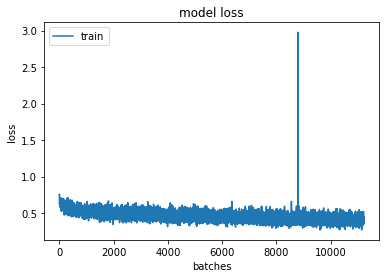

In [54]:
import matplotlib.pyplot as plt
# plt.plot(history.history['acc'])
# plt.plot(history.history['val_acc'])
# plt.title('model accuracy')
# plt.ylabel('accuracy')
# plt.xlabel('epoch')
# plt.legend(['train', 'val'], loc='upper left')
# plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('batches')
plt.legend(['train'], loc='upper left')
plt.show()

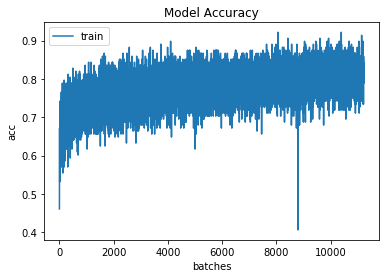

In [74]:
plt.plot(history.history['acc'])
plt.title('Model Accuracy')
plt.ylabel('acc')
plt.xlabel('batches')
plt.legend(['train'], loc='upper left')
plt.show()

225


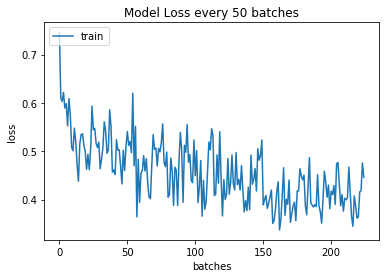

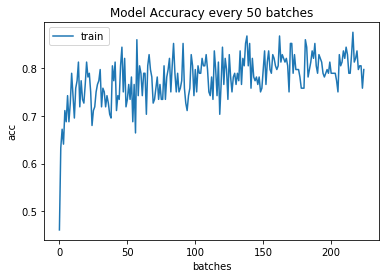

In [73]:
loss2 = history.history['loss'][0::50]
acc2 = history.history['acc'][0::50]
print len(loss2)
plt.plot(loss2)
plt.title('Model Loss every 50 batches')
plt.ylabel('loss')
plt.xlabel('batches')
plt.legend(['train'], loc='upper left')
plt.show()
plt.plot(acc2)
plt.title('Model Accuracy every 50 batches')
plt.ylabel('acc')
plt.xlabel('batches')
plt.legend(['train'], loc='upper left')
plt.show()

6
6


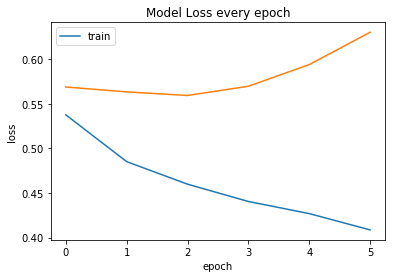

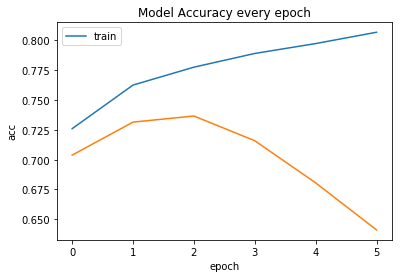

In [72]:
loss3 = [0.5377, 0.4852, 0.4599, 0.4405, 0.4269, 0.4086]
acc3 = [0.7260, 0.7626, 0.7776, 0.7891, 0.7974, 0.8069 ]

plt.plot(loss3)
plt.plot(history.history['val_loss'])
plt.title('Model Loss every epoch')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()
plt.plot(acc3)
plt.plot(history.history['val_acc'])
plt.title('Model Accuracy every epoch')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

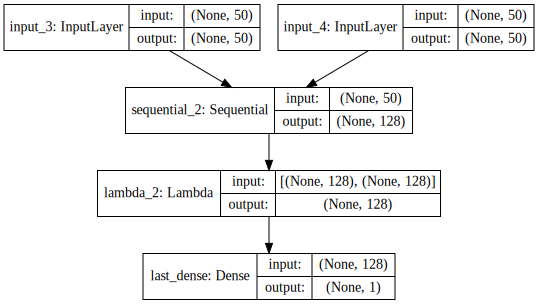

In [52]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
SVG(model_to_dot(main_model, show_shapes=True).create(prog='dot', format='svg'))

In [57]:
main_model.load_weights('weights-improvement-02-0.74.hdf5')

In [58]:
score_on_train = main_model.evaluate([X_train[0],X_train[1]],y_train, batch_size=128)

239415/239415 [==============================] - 641s   


[0.54727909250610729, 0.75305223147791389]

In [75]:
score_on_test = main_model.evaluate([X_test[0],X_test[1]],y_test, batch_size=128)

29927/29927 [==============================] - 84s    


In [76]:
score_on_test


[0.5595478467690812, 0.73572359399328369]

In [77]:
predictions = main_model.predict([X_test[0], X_test[1]] , batch_size=128, verbose = 1)

29927/29927 [==============================] - 96s    


In [78]:
len(predictions)

29927

In [92]:
low = {}
high = {}
mid = {}

i = 0
for i in range(len(predictions)):
    if abs(1.0-predictions[i])<=0.2:
        high[i] = predictions[i]
    if abs(predictions[i])<=0.2:
        low[i] = predictions[i]
    if abs(0.5-predictions[i])<=0.1:
        mid[i] = predictions[i]
        


In [99]:
mid = [0,1,6]

In [100]:
high = [305, 1966, 3367]

In [101]:
low = [16387, 4, 25942]

In [103]:
X_test[0][0]

50

In [104]:
import cPickle
f = open("reverse_word", "r")
reverse = pickle.load(f)
f.close()

In [106]:
data = pd.read_csv('./cleandata.csv')

In [111]:
print data['question1'][269342]
print data['question2'][269342]
print y_test[0]

If I don't add phone number and recovery mail address to my gmail ID how can I reset my password?
How do I reset my Gmail password when I don't remember my recovery information? 13 Answers
1


In [112]:
print data['question1'][269343]
print data['question2'][269343]
print y_test[1]

How do I correct grammatical errors in questions asked on Quora?
How does Quora correct grammatical errors in questions?
0


In [113]:
print data['question1'][269348]
print data['question2'][269348]
print y_test[0]

Is milk actually good or bad for your health?
Is drinking milk good for health?
1
